# Logistic Regression
Binary or Multiclass <br>
This notebook will show how to build a logistic regression from scratch

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The logistic regression is essentially a ***softmax classifier***. <br>
We will inplement the model with the ***softmax function, MLE(or cross-entropy) and stocahstic gradient decent***.<br> We will also add the ***regularization*** on the model to solve the problem of redundant parameters.<br>
After the model is constructed, we will test the model on the iris data <br>
We will not build a class, but only a bunch of functions, which could be easily transformed to a logistic class.

Assume that we have labeled data X,y

In [78]:
# simulate the data for test
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([0, 4], [[1, .75],[.75, 1]], num_observations)

X = np.vstack((x1, x2)).astype(np.float32)
y = np.hstack((np.zeros(num_observations, dtype='int32'),
                              np.ones(num_observations, dtype='int32')))

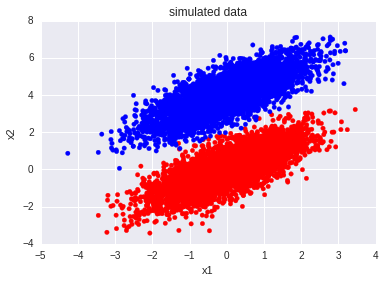

In [79]:
# visualize the simulation
colorPlate = {0:"red",1:"blue"}
colors = [colorPlate[c] for c in y]
plt.scatter(X[:,0], X[:,1], color = colors);
plt.title("simulated data");
plt.xlabel("x1");
plt.ylabel("x2");

Initialize the parameters

In [146]:
def init_params(X,y):
    # get number of classes
    Nclass = len(np.unique(y))
    Nfeature = X.shape[1]
    
    # initalize parameters
    # Weights for different classes
    W = np.random.randn(Nclass, Nfeature)

    # bias for different classes
    b = np.random.randn(Nclass)
    
    return W, b

In [147]:
np.random.seed(1212)
W, b = init_params(X,y)

In [148]:
def softmax(x):
    
    orig_shape = x.shape
    x = x - np.max(x)
    x = np.exp(x)/np.sum(np.exp(x))

    assert x.shape == orig_shape
    return x

We will write a function "softmaxGradient" to calculate the cost of one input and return the cost and gradient<br>
For each input, we can get the gradient for the W and b and update them during the iteration

In [149]:
def softmaxGradient(predictor, target, weights, bias, l = 0.05):
    """
    predictor is one row of the data
    target is the corresponding label of classes
    W and b are weights and bias
    The regularization is also added to prevent redundant parameters
    """
    # get y_hat
    y_hat = softmax(np.dot(weights, predictor) + bias)

    # get cost
    cost = -np.log(y_hat[target])
    y_hat[target] -= 1

    # get grad with regularization
    gradW = np.outer(y_hat, predictor) + 2*l*weights
    gradb = y_hat + 2*l*bias
    return cost, gradW, gradb

In [150]:
# test
np.random.seed(4321)
cost, gradW, gradb = softmaxGradient(X[0,:], y[0], W, b)

In [151]:
print(cost, "\n" ,gradW, "\n", gradb)

0.119901530963 
 [[ 0.0965051   0.01548445]
 [ 0.02352315 -0.11163319]] 
 [-0.01503587  0.01802801]


Then, we have to optimize the parameters. We will use the Stochastic gradient descent here<br>
The function will return the updated weights

In [152]:
def sgd(X, y, f, weights, bias, lr=0.01, epochs=100, batchSize=10, PRINT_EVERY=100):
    Ndata = X.shape[0]
    index = np.array(range(Ndata)) 
    
    for i in range(epochs):
        
        # shuffle X and y
        expcost = None # cost accumulation
        np.random.shuffle(index) 
        X = X[index,:]
        y = y[index]
        
        XBatch = [X[k:k+batchSize,:] for k in np.arange(0, Ndata, batchSize)]
        yBatch = [y[k:k+batchSize] for k in np.arange(0, Ndata, batchSize)]
        gradWSum = np.zeros(weights.shape) # initialize the weights
        gradbSum = np.zeros(bias.shape) # initialize the bias
        
        for xb, yb in zip(XBatch, yBatch):
            bSize = len(yb)
            for j in range(bSize):
                cost, gradW, gradb = f(xb[j,:], yb[j], weights, bias) # calc gradients
                if expcost:
                    expcost = 0.95*expcost + 0.05*cost
                else:
                    expcost = cost
                assert gradW.shape == gradWSum.shape
                assert gradb.shape == gradbSum.shape
                gradWSum += gradW # accumulate batch gradient of W
                gradbSum += gradb # accumulate batch gradient of b
            weights -= lr * (1/bSize) * gradWSum # update W
            bias -= lr * (1/bSize) * gradbSum # update b
            
        if (i+1) % PRINT_EVERY == 0:
            print("Training cost after epoch {} is: {}".format(i+1, expcost))
        
    return weights, bias

In [153]:
np.random.seed(4321)
WNew, bNew = sgd(X, y, softmaxGradient, W, b, 0.001, 20, 10, 1)

Training cost after epoch 1 is: 0.2616926973869144
Training cost after epoch 2 is: 0.18465064592321712
Training cost after epoch 3 is: 0.24040897227896937
Training cost after epoch 4 is: 0.1631073304398386
Training cost after epoch 5 is: 0.15727737909904096
Training cost after epoch 6 is: 0.17683756337684647
Training cost after epoch 7 is: 0.15407386404362605
Training cost after epoch 8 is: 0.1926206663332953
Training cost after epoch 9 is: 0.1621294407287406
Training cost after epoch 10 is: 0.1629595061288344
Training cost after epoch 11 is: 0.11870047767223764
Training cost after epoch 12 is: 0.11889319828556337
Training cost after epoch 13 is: 0.13470934894238865
Training cost after epoch 14 is: 0.19816824218152537
Training cost after epoch 15 is: 0.13699817923228713
Training cost after epoch 16 is: 0.18473093578376965
Training cost after epoch 17 is: 0.15463499315799611
Training cost after epoch 18 is: 0.18127911322889528
Training cost after epoch 19 is: 0.16092041921496822
Trainin

Then we use the logistic model to predict for the training data

In [157]:
def predict(X,W,b):
    return np.argmax(softmax(np.dot(X,W) + b.reshape(1,-1)))

In [158]:
pred = []
for i in range(len(y)):
    pred.append(predict(X[i,:], WNew, bNew))

In [159]:
sum(pred == y)/len(y)

0.99490000000000001

Compare with sklearn

In [160]:
from sklearn.linear_model import LogisticRegression

np.random.seed(4321)
logistic = LogisticRegression(penalty='l2', fit_intercept=True, C = 200, max_iter=20)
logistic.fit(X, y)

LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [161]:
pred = logistic.predict(X)

sum(pred == y)/len(y)

0.99929999999999997

Then we can visualize the boundary

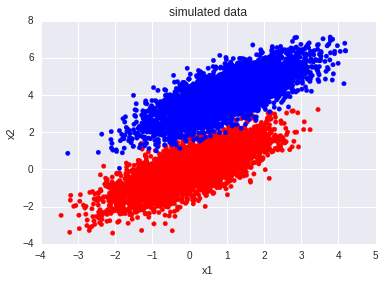

In [117]:
# visualize the simulation
colorPlate = {0:"red",1:"blue"}
colors = [colorPlate[c] for c in y]
plt.scatter(X[:,0], X[:,1], color = colors);
plt.title("simulated data");
plt.xlabel("x1");
plt.ylabel("x2");